In [1]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
import shap
import torch
from torch import nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md

KeyboardInterrupt: 

In [ ]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [ ]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load Data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [8]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns
w = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0]

In [9]:
X = torch.Tensor(np.hstack((cv_arr, sb_arr)))
y = torch.Tensor(np.concatenate(q)).unsqueeze(-1)
print(X.shape, y.shape)

torch.Size([4150115, 62]) torch.Size([4150115, 1])


In [10]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        feature_names.append(f"{r} C$_\\alpha$—{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\varepsilon$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}—F161")

## load networks

In [11]:
from ga import MultiLayerNet

In [12]:
input_dim = X.shape[-1]
hidden_dim = 30
output_dim = 1

In [13]:
nets = []
for i in range(5):
    mlp = MultiLayerNet(input_dim, hidden_dim, output_dim)
    state_dict = torch.load(f"nn_deep5_w30_{i}.dat")
    mlp.load_state_dict(state_dict)
    nets.append(mlp)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [15]:
print(torch.cuda.device_count())

0


# SHAP values

In [15]:
X1000 = shap.utils.sample(X, 1000)

In [16]:
def predict(net):
    def f(X):
        return net([X[:,i] for i in range(X.shape[1])]).flatten()
    return f

## Regular explainer

In [ ]:
def masker(*model

In [42]:
explainer = shap.Explainer(nets[0], )

In [43]:
shap_lin = explainer(X[:10])


Compilation is falling back to object mode WITH looplifting enabled because Function "_delta_masking" failed type inference due to: non-precise type pyobject
During: typing of argument at /project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/shap/maskers/_tabular.py (203)

File "../../../anaconda3/envs/py39/lib/python3.9/site-packages/shap/maskers/_tabular.py", line 203:
def _delta_masking(masks, x, curr_delta_inds, varying_rows_out,
    <source elided>

    dpos = 0
    ^

Function "_delta_masking" was compiled in object mode without forceobj=True.

File "../../../anaconda3/envs/py39/lib/python3.9/site-packages/shap/maskers/_tabular.py", line 196:
@jit
def _delta_masking(masks, x, curr_delta_inds, varying_rows_out,
^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fa

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Deep explainer

In [47]:
e = shap.DeepExplainer(nets[0], X1000)

In [ ]:
shap_values_de = e.shap_values(X[::100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [55]:
np.save("deep_exp_shap_skip100", shap_values_de)

In [56]:
shap_values_de.shape

(41502, 62)

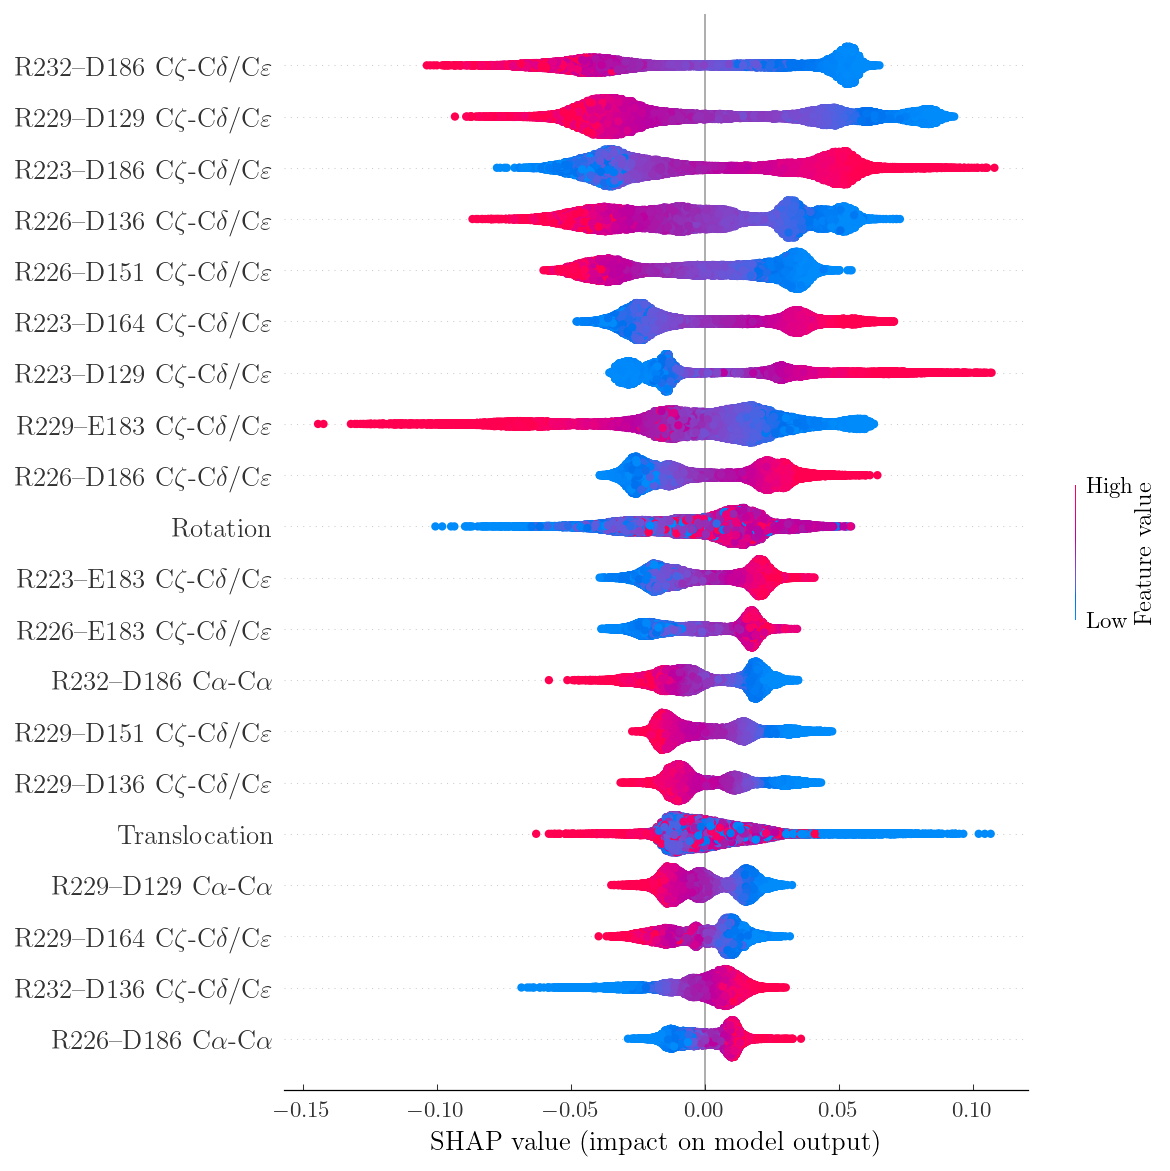

In [65]:
shap.summary_plot(shap_values_de, X[::100], feature_names)

# Gradient Explainer

In [27]:
grad_exp = shap.GradientExplainer(nets[0], X1000, )

In [39]:
shap_values = grad_exp.shap_values(X[::100])

In [40]:
np.save("grad_exp_shap_skip100", shap_values)

<BarContainer object of 62 artists>

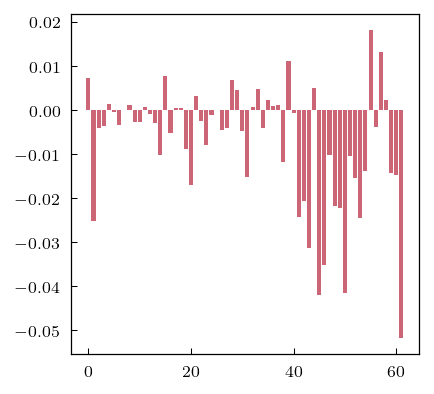

In [35]:
plt.bar(np.arange(62), shap_values[0])

In [43]:
sb_labels[-1]

'R232 - D186'

In [46]:
sb_labels[41-30]

'R223 - D186'

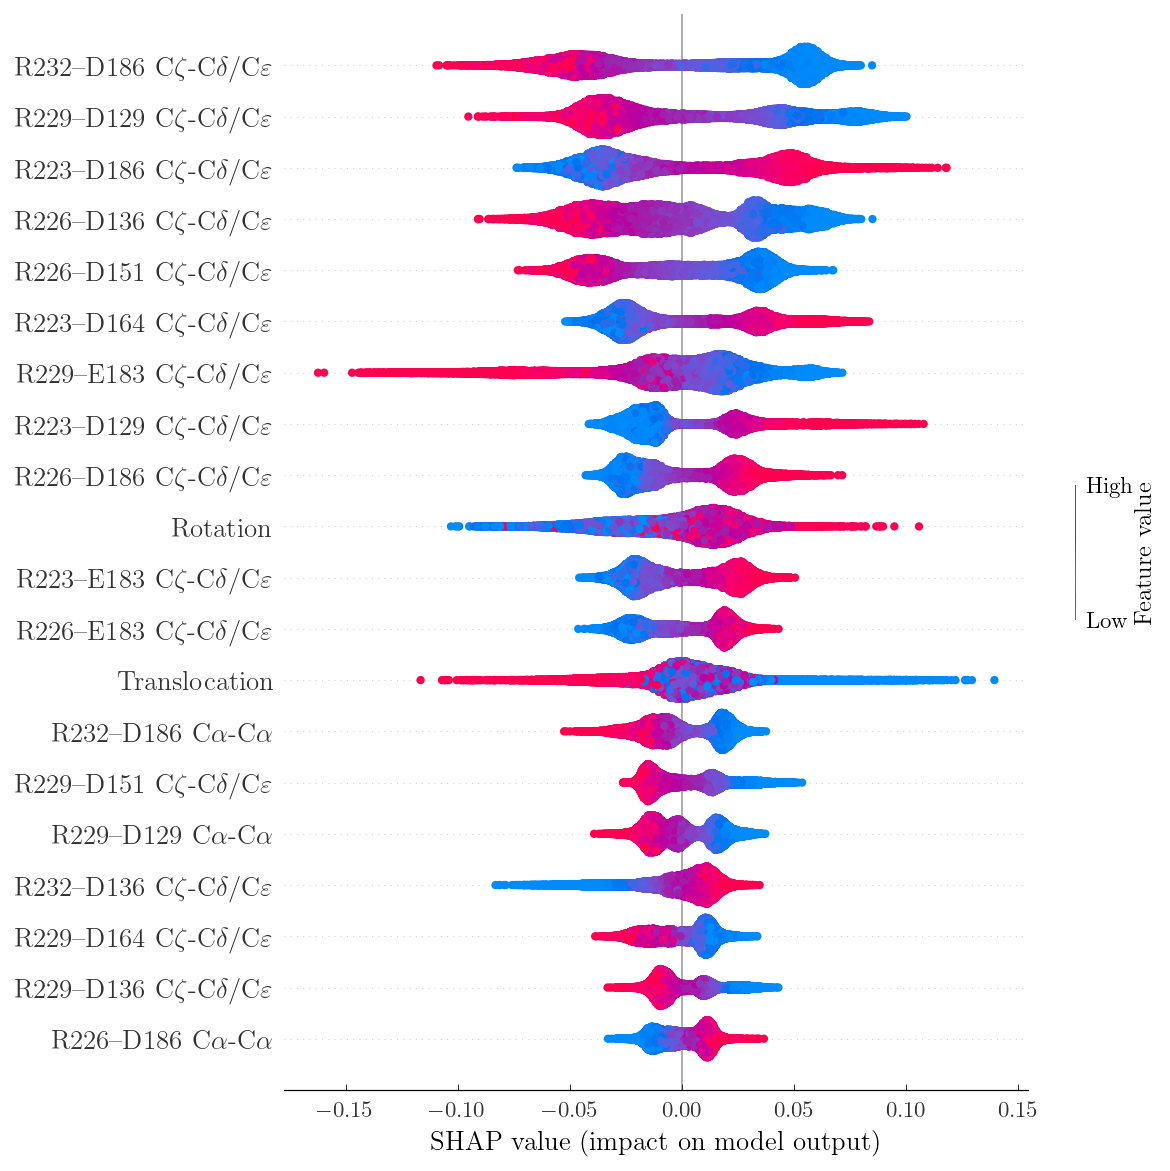

In [67]:
shap.summary_plot(shap_values, features=X[::100], feature_names=feature_names)

# Transition region

In [17]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [26]:
cutoff = 0.2
q_arr = np.concatenate(q)
mid_idx = ((q_arr > cutoff) & (q_arr < 1 - cutoff)).nonzero()[0]
X_trans = X[mid_idx]
y_trans = y[mid_idx]

In [27]:
print(X_trans.shape)

torch.Size([1282655, 62])


In [28]:
X1000 = shap.utils.sample(X_trans, 1000)

In [29]:
e = shap.DeepExplainer(nets[0], X1000)

In [30]:
shap_values_de = e.shap_values(X_trans[::100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [31]:
np.save("deep_exp_shap_skip100_trans", shap_values_de)

In [32]:
shap_values_de.shape

(12827, 62)

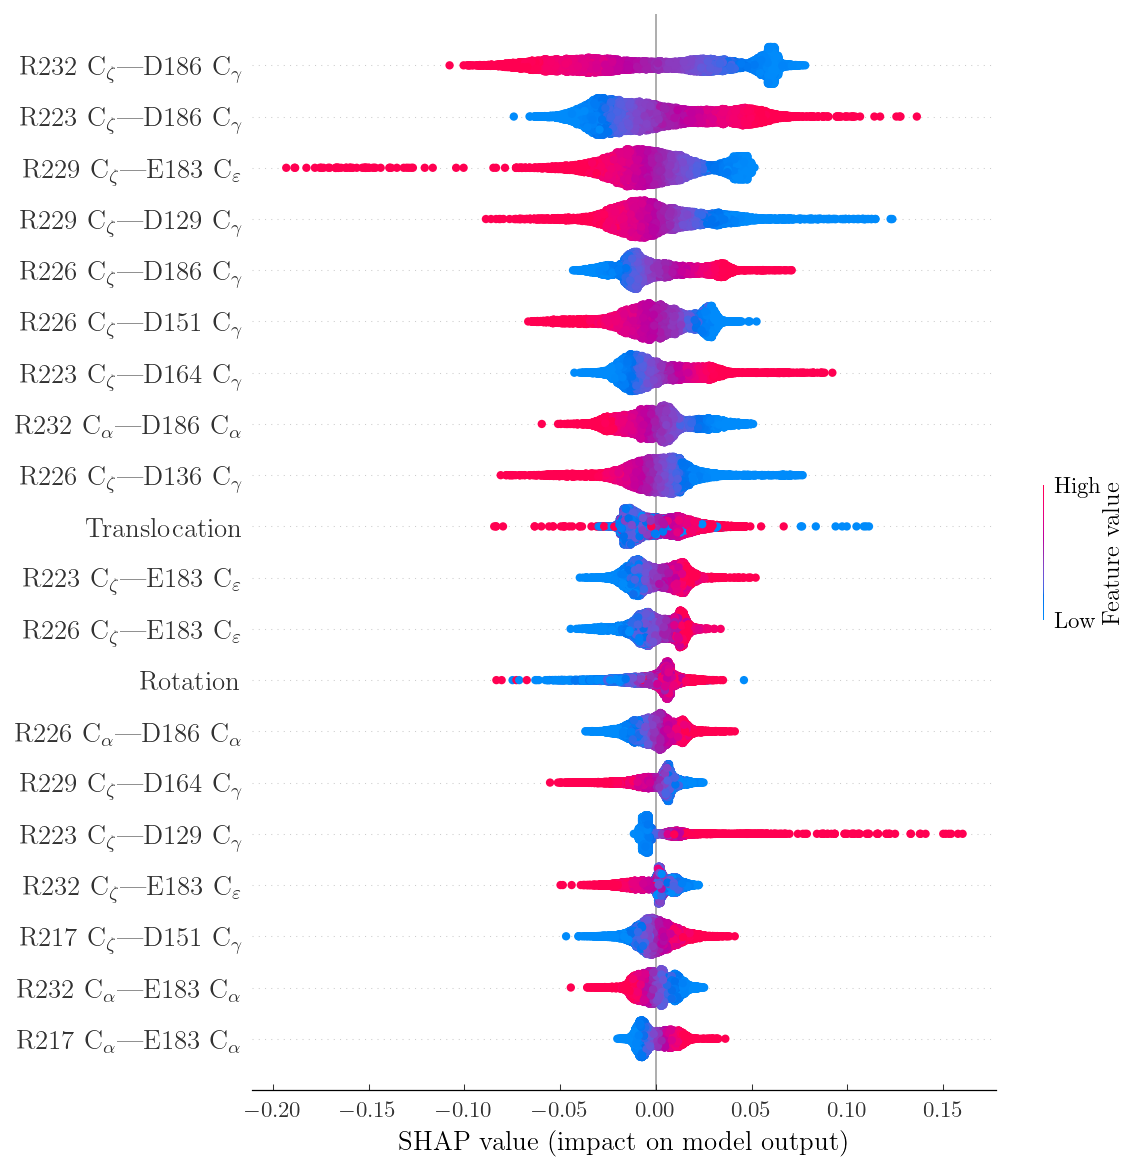

In [33]:
shap.summary_plot(shap_values_de, X_trans[::100], feature_names)